# Как использовать SyntaxNet

Автор - **Евгений Смирнов** (jeka.mts@gmail.com)

[SyntaxNet](https://github.com/tensorflow/models/tree/master/syntaxnet) - инструмент для построения синтаксических деревьев. 

В данном туториале расматривается:

* Подготовка данных для SyntaxNet
* Запуск SyntaxNet
* Обработка его выхода
* Выделение синтаксических веток из дерева
* Отбор синтаксических коллокаций
* Построение батчей из синтаксических веток
* WSTM

In [18]:
import codecs
import pandas as pd
import numpy as np
from tools import *
import regex as re
import shutil
import time
import operator
from math import log
import csv
import matplotlib.pyplot as plt

## Подготовка данных для SyntaxNet

SYNTAXNET_MODELS_PATH --- путь к директории с моделями

SYNTAXNET_MODELS_PATH/Russian-SynTagRus должна содержать модель для русского языка

In [7]:
# Folders
FOLDER = "data_mini/"
FILES_FOLDER = FOLDER + "news/"
FOLDER_COLLOCATION = FOLDER + "collocations/"

# SyntaxNet 
SYNTAXNET_INPUT = FOLDER + "to_syntaxnet.txt"
SYNTAXNET_OUTPUT = FOLDER + "from_syntaxnet.txt"
SYNTAXNET_OUTPUT_PKL = FOLDER + "from_syntaxnet.pkl"
SYNTAXNET_MODELS_PATH = "~/Python_libs/models/syntaxnet/syntaxnet/models"

# ouput data
META_DATA = FOLDER + "meta_data.pkl"
DOCUMENT_SENTENCES = FOLDER + "document_sentences.pkl"
STOP_WORDS = FOLDER + "stop_words.txt"
BRANCHES = FOLDER + "branches.pkl"
COLLOCATIONS = FOLDER + "collocations.txt"

#dataFrames' columns
COLUMN_DOCUMENT_NAME = "document_name"
COLUMN_TITLE = "title"
COLUMN_URL = "url"
COLUMN_TIME = "time"
COLUMN_CATEGORY = "category"
COLUMN_SUBCATEGORY = "subcategory"
COLUMN_SENTENCE = "sentence"
COLUMN_LEMMATIED = "lemmatized"
COLUMN_BRANCH = "branch"
COLUMN_WITH_COLLOCATIONS = "with_collocations"

ERROR_MESSAGE = "something has gone wrong"

Подготовим список предложение, а также сохраним метаданные.

**Грабли**:
* Важно удалить все символы не относящиеся к русскому и англискому языкам, иначе могут возникнуть проблемы при лемматизации на следующем шаге.

In [3]:
documents_name = []
titles = []
urls = []
times = []
categories = []
subcategories = []

sentences = []
documents_id = []

file_list = os.listdir(FILES_FOLDER)
files_n = len(file_list)

for document_id, file_name in enumerate(os.listdir(FILES_FOLDER)):
    
    with codecs.open(FILES_FOLDER + file_name, encoding="utf-8") as input_file:
        input_lines = input_file.read().split("\n")
        
    documents_name.append(file_name)
    titles.append(input_lines[1])
    urls.append(input_lines[3])
    times.append(input_lines[5])
    categories.append(input_lines[7])
    subcategories.append(input_lines[9])
    
    for line in input_lines[11:]:
        for sentence in line.split("."):
            sentence_nopunctuation =  re.sub(ur'[^A-Za-zА-Яа-я ]', u'', sentence).lower().rstrip().strip()
            if sentence_nopunctuation:
                sentences.append(sentence_nopunctuation)
                documents_id.append(document_id)

Сохраним метаданные

In [4]:
meta_data = pd.DataFrame()
meta_data[COLUMN_DOCUMENT_NAME] = documents_name
meta_data[COLUMN_TITLE] = titles
meta_data[COLUMN_URL] = urls
meta_data[COLUMN_TIME] = times
meta_data[COLUMN_CATEGORY] = categories
meta_data[COLUMN_SUBCATEGORY] = subcategories
meta_data.to_pickle(META_DATA)

document_sentences = pd.DataFrame()
document_sentences[COLUMN_SENTENCE] = sentences
document_sentences.to_pickle(DOCUMENT_SENTENCES)

Запишем все предложения в один файл: на одной строчке одно предложение.

In [13]:
with codecs.open(SYNTAXNET_INPUT, "w", encoding="utf-8") as output:
    print >> output, "\n".join(sentences)
print "lines number = {}".format(len(sentences))

lines number = 13057


## Запустим SyntaxNet

**Хотелки**:
* передавать данные непосредственно, минуя запись на диск
* решим проблему со скоростью работы

In [12]:
start_time = time.time()
if os.system("./run_syntaxnet.sh {} {} {}".format(SYNTAXNET_INPUT, SYNTAXNET_OUTPUT, SYNTAXNET_MODELS_PATH)) != 0:
    print ERROR_MESSAGE
print "It took {:.2f} seconds".format(time.time() - start_time)

It took 403.78 seconds


Посмотрим на выходной файл от SyntaxNet

In [14]:
from_syntaxnet = pd.read_csv(SYNTAXNET_OUTPUT, encoding="utf-8", header=None, sep="\t", engine="c",
                             quoting=csv.QUOTE_NONE)
from_syntaxnet.head()

,0,1,2,3,4,5,6,7,8,9
0,1,бои,_,NOUN,_,Animacy=Inan|Case=Nom|Gender=Masc|Number=Plur|...,6,nsubj,_,_
1,2,у,_,ADP,_,fPOS=ADP++,3,case,_,_
2,3,сопоцкина,_,NOUN,_,Animacy=Anim|Case=Gen|Gender=Masc|Number=Sing|...,1,nmod,_,_
3,4,и,_,CONJ,_,fPOS=CONJ++,1,cc,_,_
4,5,друскеник,_,NOUN,_,Animacy=Anim|Case=Nom|Gender=Masc|Number=Sing|...,1,conj,_,_


# Обработаем выход SyntaxNet:
* Селекция столбцов
* Именование столбцов
* Добавим колонку с лематизированным словами
* Сделаем индексацию с нуля

Сохраним результат в формате pickle

**Грабли**:
* не забываем про кодировку
* иногда pandas может сломаться на следующей конструкции : **'"'** --- используем quoting=csv.QUOTE_NONE

**Хотелки**:
* Распараллелить работу mystem
* Добавить обработку знаков препинания

In [15]:
from process_assessors_topics import syntaxnet_post_process
from_syntaxnet = syntaxnet_post_process(SYNTAXNET_OUTPUT)
from_syntaxnet.to_pickle(SYNTAXNET_OUTPUT_PKL)
from_syntaxnet.head()

line 190000 from 193397

,word_id,word,parent_id,tag,dependency,sentence_id,lemmatized
0,0,бои,5,NOUN,nsubj,0,бой
1,1,у,2,ADP,case,0,у
2,2,сопоцкина,0,NOUN,nmod,0,сопоцкин
3,3,и,0,CONJ,cc,0,и
4,4,друскеник,0,NOUN,conj,0,друскеник


### Отбросим стоп слова

**Грабли**:
* не забудьте откинуть низкочастотные слова, если вам кто-то прислал свои стоп-слова перепроверьте их. Помните, большой словарь = долго длительное ожидание. Вряд ли низкочастотные слова сыграют ключевую роль в вашей модели.

**Хотелки**
* Для более честного отбора стоп-слов было бы здорово научиться сливать(стеминг не подходит) однокоренные слова в один токен

In [16]:
lemmas = dict()
for word in from_syntaxnet[COLUMN_LEMMATIED]:
    if word in lemmas:
        lemmas[word] += 1
    else:
        lemmas[word] = 1

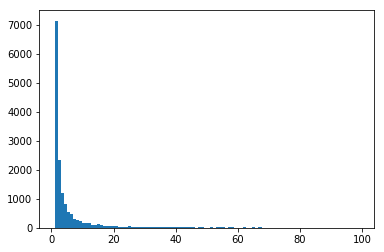

In [19]:
lemmas_new = {token:frequency for token, frequency in lemmas.iteritems() if frequency < 100}
values = np.array(lemmas_new.values())
plt.hist(values, bins=100)
plt.show()

In [26]:
stop_words = getSetFromFile(STOP_WORDS)
vocab = set([token for token, frequency in lemmas.iteritems() if frequency > 10])
vocab = vocab.difference(stop_words)
print "from {} tokens were selected {} to vocabulary".format(len(lemmas), len(vocab))

from 15868 tokens were selected 2135 to vocabulary


# Выделение синтаксических веток из дерева

Синтаксическая ветка --- последовательность слов от корня дерева до любого из его листьев.

Загрузим стоп-слова или словарь --- выбираем меньшее по мощности множетсов. Зададим части речи для фильтрации.

**Грабли**:
* стоп-слова лучше удалять на этом этапе чтобы не плодить одинаковые ветки

**Хотелки**:
* распараллелить

In [27]:
from Branches import *
branches = Branches(vocab=vocab, bad_tags={u'ADP', U'CONJ', U'AUX', U'PRON', U'NUM', U'SCONJ'})

Получим синтаксические ветки из результата синтаксического анализа. 

addTags --- Для каждой пары частей речи составим словарь частот соответствующих им словосочетаний.

In [28]:
branches.addDataFrame(from_syntaxnet, addTags=True)

word 190000 from 193397

Сохраним синтаксические ветки на диск

In [29]:
branchesDataFrame = branches.outputData.getDataFrame()
branchesDataFrame.to_pickle(BRANCHES)
print "\nЧисло веток - {}".format(len(branchesDataFrame))
branchesDataFrame.head()


Число веток - 40122


,sentence_id,branch_id,branch,word_ids_local,word_ids_global
0,0,0,заканчиваться бой,"[5, 0]","[5, 0]"
1,1,0,начинать север,"[6, 3]","[14, 11]"
2,1,1,начинать борьба артиллерийский,"[6, 8, 7]","[14, 16, 15]"
3,2,0,бой артиллерийский,"[2, 1]","[21, 20]"
4,2,1,калибр тяжелый,"[6, 5]","[25, 24]"


# Отбор синтаксических коллокаций

In [30]:
n_pairs = sum([sum(pairs.values()) for key, pairs in branches.dictionary_pairs.iteritems()])
n_words = sum(branches.dictionary_frequency.values())
norm_coef = float((n_words) ** 2) / n_pairs

def filter_pairs(pairs, threshold_frequency, threshold_pmi):
    pairs_sorted = sorted(pairs.items(), key=operator.itemgetter(1), reverse=True)
    new_elements = []
    for element in pairs_sorted:
        pair = element[0]
        frequency = element[1]
        if frequency > threshold_frequency:
            pmi = log(norm_coef * frequency / branches.dictionary_frequency[pair[0]]
                      / branches.dictionary_frequency[pair[1]])
            if pmi > threshold_pmi:
                new_elements.append(((" ".join(pair)), frequency, pmi))
    return new_elements

**Для кажой из пар частей речи создадим файл с наиболее частыми словосочетаниями**

В этом месте наступает творческо-асессоркий момент. Чем лучше эвристики для отбора придумаете, тем лучше будут коллокации. Если творчество подводит, то всегда можно компенцировать этот недостаток асессорским трудом. Советую задать менее жесткие фильтры для отборы и внимательно отобрать принципом длительного вдумывания.

In [32]:
checkDirectory(FOLDER_COLLOCATION)
        
for key, pairs in branches.dictionary_pairs.iteritems():
    elements = filter_pairs(pairs, 10, 3)
    if elements:
        
        output = []
        for element in elements:
            output.append(u"{}: {} {:2}".format(element[0], element[1], element[2]))
                
        with codecs.open("{}{}.txt".format(FOLDER_COLLOCATION, key), "w", encoding="utf-8") as ouputFile:
            print >> ouputFile, "\n".join(output)

**Проведем асессорскую фильтрацию.**

Далее, сформируем список коллокаций.

In [33]:
collocations = []
for file_name in os.listdir(FOLDER_COLLOCATION):
    if not file_name.startswith("."):
        with codecs.open(FOLDER_COLLOCATION + file_name, encoding="utf-8") as input_file:
            collocations += [line.split(":")[0] for line in input_file.read().splitlines()]
with codecs.open(COLLOCATIONS, "w", encoding="utf-8") as output_file:
    print >> output_file, "\n".join(collocations)
print "Выделено {} коллокаций".format(len(collocations))

Выделено 437 коллокаций


In [34]:
from preprocess_line import CollocationSyntax, add_collocation

In [35]:
lines = list(branchesDataFrame[COLUMN_BRANCH])

collocations = []

for collocation in getListFromFile(COLLOCATIONS):
    collocations.append(CollocationSyntax(collocation))
    
collocations_n = len(collocations)
    
all_branches = "\n".join(lines)
    
for i, collocation in enumerate(collocations):
    if i % 10 == 0:
        dynamicPrint("added collocation {} from {}".format(i, collocations_n))
    all_branches = add_collocation(all_branches, collocation)

added collocation 430 from 437

In [36]:
new_lines = all_branches.split("\n")
for i, line in enumerate(new_lines):
    if not line:
        del new_lines[i]

Сохраним ветки на диск

In [37]:
branchesDataFrame[COLUMN_WITH_COLLOCATIONS] = new_lines
branchesDataFrame.to_pickle(BRANCHES)

# WSTM

### Создадим Vowpal Wabbit из синтаксических веток

In [38]:
from create_ww_and_pmi_count import main as prepare_batches

In [39]:
prepare_batches(branchesDataFrame[COLUMN_WITH_COLLOCATIONS], FOLDER, 7)

save wv to data_mini/ww_vw.txt

pair 172000 from 172958
save vocab to data_mini/vocab.txt

2402 from 2403
save pmi to data_mini/pmi.txt


Time elapsed: 5.725 sec.


In [40]:
import artm

In [41]:
PMI_PATH = FOLDER + "pmi.txt"
VOCAB_PATH = FOLDER + "vocab.txt"
PATH_TO_WW_VW = FOLDER + 'ww_vw.txt'
FOLDER_BATCHES_WW = FOLDER + "batches/"

In [42]:
def prepare(redo=False):
    global bv_ww
    
    if redo and os.path.exists(FOLDER_BATCHES_WW):
        shutil.rmtree(FOLDER_BATCHES_WW)
        
    if not os.path.exists(FOLDER_BATCHES_WW):
        bv_ww = artm.BatchVectorizer(data_path=PATH_TO_WW_VW, data_format='vowpal_wabbit',
                             target_folder=FOLDER_BATCHES_WW)
        d = artm.Dictionary()
        d.gather(data_path=FOLDER_BATCHES_WW, cooc_file_path=PMI_PATH, vocab_file_path=VOCAB_PATH)
        d.save(dictionary_path=FOLDER_BATCHES_WW + '/cooc_dict.dict')
    else:
        bv_ww = artm.BatchVectorizer(data_path=FOLDER_BATCHES_WW, data_format='batches')

Загрузим/создадим батчи, словарь

In [43]:
prepare(True)

In [44]:
def createTopics(domain_n=90, background_n=10):
    global DOMAIN_N, BACKGROUND_N, string_id
    DOMAIN_N = domain_n
    BACKGROUND_N =  background_n
    string_id = "d{}_b{}".format(domain_n, background_n)
    global topics_background, topics_domain
    topics_domain = ['topic_d{}'.format(i) for i in xrange(domain_n)]
    topics_background = ['topic_b{}'.format(i) for i in xrange(background_n)]

In [45]:
def addScores():
    model.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                                  dictionary=cooc_dict))
    model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore', topic_names=topics_domain))
    model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore', topic_names=topics_domain))
    model.scores.add(artm.TopicKernelScore(name='TopicKernelScore',
                                           topic_names=topics_domain, probability_mass_threshold=0.3))
    model.scores.add(artm.TopTokensScore(name='TopTokensScore',
                                         num_tokens=50, dictionary=cooc_dict))

In [46]:
def printTopics(topics, num=70, print_file=False):
    Phi = model.get_phi()
    zeros = 0
    string_to_print = ""
    for i, topic in enumerate(topics_domain + topics_background):
        if topic in topics:
            topicSeries = Phi[topic].sort_values(ascending=False)[:num]
            indexes = topicSeries > 0
            result = topicSeries[indexes].index
            string_to_print += topic + ":[{}/{}] ".format(len(result), sum(Phi[topic] > 0)) + " ".join(result) + "\n"
            zeros += len(result) == 0
    print string_to_print
    if print_file:
        with codecs.open(FOLDER + 'topics_d{}_b{}.txt'.format(DOMAIN_N, BACKGROUND_N), 'w', 'utf8') as outputFile:
            print >> outputFile, string_to_print

Зададим число предметных и фоновых тем

In [47]:
createTopics(domain_n=50, background_n=10)

In [48]:
cooc_dict = artm.Dictionary(dictionary_path=FOLDER_BATCHES_WW + '/cooc_dict.dict')
model = artm.ARTM(topic_names=topics_domain + topics_background, dictionary=bv_ww.dictionary,
                  num_document_passes=1, cache_theta=True, theta_columns_naming="title", reuse_theta=True)
addScores()
model.initialize(dictionary=cooc_dict)

Поитерируем пока модель не сойдется

In [49]:
model.fit_offline(batch_vectorizer=bv_ww, num_collection_passes=40)

Сгладим фоновые темы и декоррелируем предметные

In [52]:
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SmoothPhi', tau=0.02, topic_names=topics_background))
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SmoothTheta', tau=0.02, topic_names=topics_background))
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi',
                                                       tau=5000, topic_names=topics_domain))

model.fit_offline(batch_vectorizer=bv_ww, num_collection_passes=30)

In [53]:
df_scores = pd.DataFrame(data = {'Sparsity Phi' : [round(model.score_tracker['SparsityPhiScore'].last_value, 3)],
                    'Sparsity Theta' : [round(model.score_tracker['SparsityThetaScore'].last_value, 3)],
                    'Kernel contrast' : [round(model.score_tracker['TopicKernelScore'].last_average_contrast, 3)],
                    'Kernel purity' : [round(model.score_tracker['TopicKernelScore'].last_average_purity, 3)],
                    'Coherence' : [round(model.score_tracker['TopTokensScore'].average_coherence[-1], 3)],
                    'Perplexity' : [round(model.score_tracker['PerplexityScore'].last_value, 3)]},
                    index = ['1'])
df_scores

,Coherence,Kernel contrast,Kernel purity,Perplexity,Sparsity Phi,Sparsity Theta
1,0.62,0.54,0.407,442.866,0.623,0.602


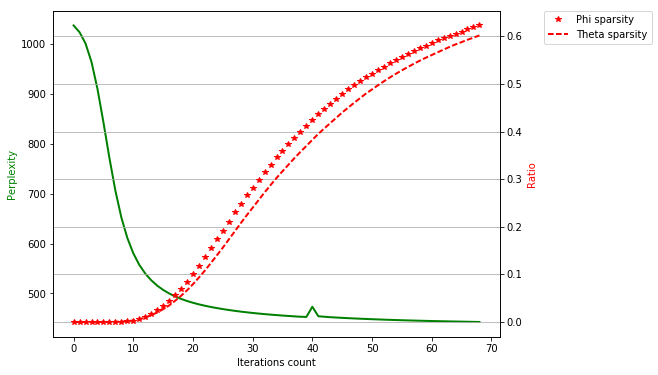

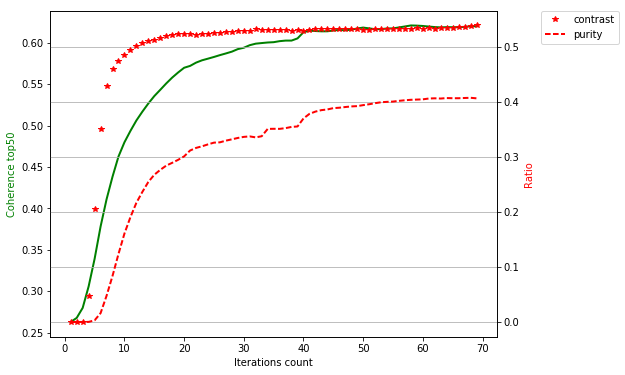

In [54]:
%matplotlib inline
import matplotlib.pyplot as plt
# convergence
x = range(len(model.score_tracker['PerplexityScore'].value[1:]))
fig, ax1 = plt.subplots(figsize=(8, 6))
ax1.plot(x, model.score_tracker['PerplexityScore'].value[1:], 'g-', linewidth=2, label="Perplexity")
ax1.set_xlabel('Iterations count')
ax1.set_ylabel('Perplexity', color='g')
ax2 = ax1.twinx()
ax2.plot(x, model.score_tracker['SparsityPhiScore'].value[1:], 'r*', linewidth=2, label="Phi sparsity")
ax2.plot(x, model.score_tracker['SparsityThetaScore'].value[1:], 'r--', linewidth=2, label="Theta sparsity")
ax2.set_ylabel('Ratio', color='r')
ax2.legend(bbox_to_anchor=(1.10, 1), loc=2, borderaxespad=0.)
plt.grid(True)
fig.savefig(FOLDER + 'convergence{}_{}.eps'.format(DOMAIN_N, BACKGROUND_N), bbox_inches='tight')
plt.show()
    
# interpretability
x = range(model.num_phi_updates)[1:]
fig, ax1 = plt.subplots(figsize=(8, 6))
ax1.plot(x, model.score_tracker['TopTokensScore'].average_coherence[1:], 'g-', linewidth=2, label="size")
ax1.set_xlabel('Iterations count')
ax1.set_ylabel('Coherence top50', color='g')
ax2 = ax1.twinx()
ax2.plot(x, model.score_tracker['TopicKernelScore'].average_contrast[1:], 'r*', linewidth=2, label="contrast")
ax2.plot(x, model.score_tracker['TopicKernelScore'].average_purity[1:], 'r--', linewidth=2, label="purity")
ax2.set_ylabel('Ratio', color='r')
ax2.legend(bbox_to_anchor=(1.10, 1), loc=2, borderaxespad=0.)
plt.grid(True)
fig.savefig(FOLDER + 'interpretability{}_{}.eps'.format(DOMAIN_N, BACKGROUND_N), bbox_inches='tight')
plt.show()
plt.clf()

In [121]:
printTopics(topics_domain + topics_background, print_file=True)

topic_d0:[70/1857] известный исполнять сниматься сыграть играть прославляться исполнение доставаться женский придумывать мужской представать важный выдвигаться исполнительница выбор запоминаться доктор прозвище отводить примеривать ложиться традиционный комедия неизвестно попробовать отказ тор рояль хит совмещать распределять перепутывать укреплять заказчик любимый отводиться подталкивать ньюйорка занятый щит воссоединяться намекать познакомиться похвалить питер феникс наставник знаменитый преподавать станцевать чей спорить сосредотачиваться помнить приписывать имитация стоун поспорить фильмография гласить гендерный вызов исполняться пробовать мистер биографический исполнение_отстранять дерзкий росомаха
topic_d1:[70/2434] размер сумма денежный особо хищение мошенничество вознаграждение взятка_получение выручать выделение перевод взыскание возврат отмывание выражение наличный собранный расходование франк вовлекать вкладывать легализация эпизод взятка незаконно косметический вымогательст